# What is Feature Engineering 

**1. Learning What? :** 

- determine which features are the most important with mutual information.
- invent new features in several real-world problem domains.
- encode high-cardinalir categoriew with a target encoding. 
- create segmentation features with k-means clustering
- decompose a dataset's variation into feature with principal component analysis.

**2. The Goal of Feature Engineering :** 

The goal of feature engineering is simply to make your data better suited to the problem at hand.  

Consider "apparent temperature" measures like the heat index and the wind chill. These quantities attempt to measure the perceived temperature to humans based on air temperature, humidty, and wind speed, things which we can measure directly. You could think of an apparent temperature as the result of a kind of feature engieerning, an attemp to make the observed data more relevant to what we actually care about. 

- improve a model's predictive performance
- reduce computational or data needs
- improve interpretability of the results 

**3. A Guiding Priciple of Feature Engineering :**

For a feature to be useful, it must have a relationship to the target that your model is able to learn. Linear model, for instance, are only able to learn linear relationship. So, when using a linear model, your goal is to transform the features to make their relationship to the target linear.  

The key idea here is that a transformation you apply to a features becomes in essence a part of the model itself. Say you were trying to predict the Price of square plots of land from the Length of one side. Fitting a linear model directly at Length gives poor results.   

If we square the Length features to get "Area", however, we create a linear relationship. Adding Area to the feature set means this linear model can now fit a parabola. Squaring a feature, in other words, gave the linear model the ability to fit squared features.  

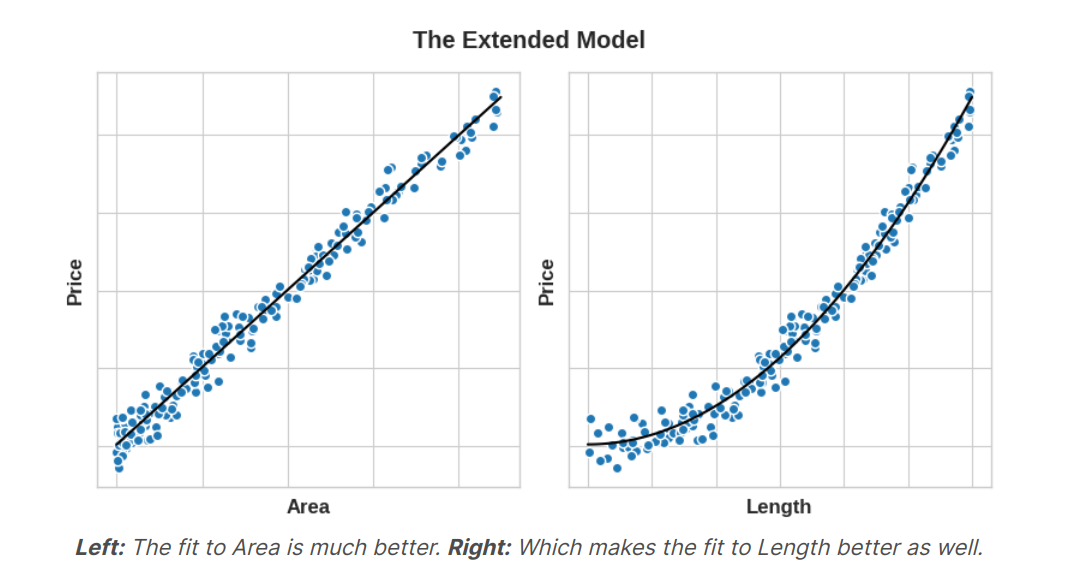



**4. Example - Concrete Formulations**

To illustrate these ideas we'll see how adding a few synthetic features to a dataset can improve the predictive performance of a randomforest model.  

The Concrete datasets contains a variety of concrete formulations and resulting products's compressive strength, which is a measure of how much load that kind of concrete can bear. The task for dataset is to predict a concrete's compressive strength given its formulation.

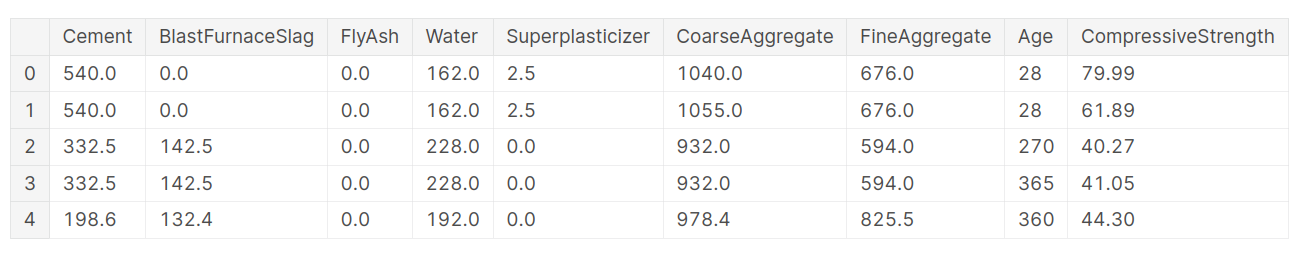

You can see here the various ingredients going into each variety of concrete. We'll see in a moment how adding some additional synthetic features derived from these can help a model to learn important relationships among them.

We'll first establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful. 

Establishing baselines like this is good practice at the start of the feature engineering process. A baseline score can help you decide wheter your new features are worth keeping, or whether you should discard them and possibly try something else. 

In [ ]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="mae", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

If you ever cook at home, you might know that the ratio of ingredients in a recipe is usually a better predictor of how the recipe turns out than thier absolute amounts. We might reason then that ratios of the features above would be a good predictor of CompressiveStrenght. 

In [ ]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="mae", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

# Mutual Infromation

First encountering a new datasets can sometimes feel overwhelming. You might be preseneted with hundreds or thousands of features without even a description to go by. Where do you even begin?  

A great first step is to construct a ranking with a feature utility metric, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful feature and the target. Then you can choose a smaller set of the most useful features to develop initally and have more confidence that your time will be well spent.  

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it mesures a relationship between two quantities. The advantage of mututal information is that it can detect any kind of relationship, while correlation only detects linear relationships.  

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is : 

- easy to use and interpret,
- computationally efficient,
- theoretically well-founded,
- resistant to overfitting, and, 
- able to detect any kind of relationship

**1. Mutual information and what it measures**

Mutual information descirbes relationships in terms of uncertainty. The mutual information between two quantities is a meausre of the extent to which knowledge of one qualitiy reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?


**2. Interpreting Mutual information Scores**

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent : neither can tell you anything about the other. Coversly, in theroy there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. 

Here are some things to remember when applying mutual information : 
- MI can help you to understand the relative potential of a features as a predictor of the target, considered by itself. 
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactiosn between features. It is a univariate metric.
- The actural usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Jsut becuase a feature has high MI score doesn't mean you model will be able to do anything with that information. you may need to transform the feature first to expose the association.

**3. What need to focus**

1. The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that must have a flaot dtypes is not discrete. Categorical can be treated by giving them a label encoding(or ordinaly encoding). 

2. Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets(mutual_info_regresion) and one for categorical targets(mutual_info_classif).

In [3]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Data visulaization is a great addition to your feature-engineering toolbox. Along with utility metrics like mutual information, visualization like these can help you discover important relationships in your data. 

# Creating Features 

Once you've identified a set of features with some potential, it's time to start developing them. In this lesson, you'll learn a number of common transformation you can do entirely in Pandas.

**1. Tips on Discovering New Features**

- Understand the features. Refer to your dataset's data documentation, if available. 
- Reserach the problem domain to acquire domain knowledge. If your problem is predicting house prices, do some research on real-estate for instance. Wikipedia can be a good starting point, but books and journal articles will often have the best information. 
- Study previous work. Solution write-ups from past Kaggle competiotions are a greeat resource.
- Use data visualization. Visualization can reveal pathologies in the distribution of a feature or complicated relationships that colud be simplified. Be sure to visualize your dataset as you work through the feature engineering process.

**2. Mathematical Transforms**

Relationships among numerical features are often expressed through mathmatical formulas, which you'll frequently come across as part of your domain researhc. In pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers. Data visualization can suggest transformations, often a "reshaping" of a feature trhough powers or logarithms.  

**3. Counts**

Features describing the presence or absence of something oftten come in sets, the set of risk factor for disease, say. You can aggregate such features by creating a count. These features will be binary( 1 for Present, 0 for Absent ) or boolen (True or False). In Python, booleans can be added up jus as if they were integers. 

In traffic accidents are several features indicating wheter some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the sum method : 

You could also use a dataframe's built-in methods to create boolean values. In the Concrete dataset are the amounts of components in a concrete formulation. Many formulations lack one or more componets. This wil count how many components are in a formulation with the dataframe's built-in greater-than gt method : 


In [1]:
# 2) Mathematical Tranform

autos["displacement"] = (
    np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos.num_of_cylinders
)

# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);

# 3) Counts

roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

NameError: name 'autos' is not defined

**4. Building-Up and Breaking-Down Features**

Often you'll have complex strings that can usefully be broken into simpler pieces. Some common examples : 
- ID numbers : '123-456-789'
- Phone numbers : '(999) 555-0123'
- Stret address : '8241 Kaggle Ln., Goose City, NV'

Features like these will often have soem kind of structure that you cna make use of. US phone numbers, for instance that tells you the location of the caller, As always, some research can pay off here.

The str accesor lets you apply string method like split directly to columns. 

**5. Group Transforms**

Finally we have group transforms, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like : "the average income of a person's state of residence", or "the proportion of movies released on a weekday, by gnere." If you had discovered a categroy interaction, a group transform over that category could be something good to investigate. 

Using an aggregation fucntion, a group transform combines two features : a categorical features that provides the grouping and another feature whose value you wish to aggregate. For an "average income by state", you would choose State for grouping feature mean for the aggregation function and Income for the aggregated feature. To compute this in Pandas, we use the groupby and transform method : 

In [2]:
customer["AverageIncome"] = (                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

# Frequency of categorical value 

customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

NameError: name 'customer' is not defined

**6. Tips on Creating Features**

- Linear models learn sums and differneces naturally, but can't learn anything more complex. 

- Ratios seem to be difficult for most model to learn. Ratio combinations often lead to some easy performance gains. 

- Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to valud not too far from 0. Tree-based models (like random forest and XGBoost) can sometimes benefit from normalization, but usually much less so. 

- Tree models can learn to approximate almost any combination of features, but when a combination is expecially important they can still benefit from having it explicitly created, especially when data is limited. 

- Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once. 

# Clustering with K-Means

This lesson and the next make use of what are known unsupervised learning algorithms. Unsupervised algorithms don't make use of a target; instead, thier purpose is to learn some property of the data, to represent the structure of the features in a certain way. In the context of feature engineering for predictions, you could think of an unsupervised algorightms as a "feature discovery" technique.

Cluertering simply means the assigning of data points to group based upon how similar the points are to each other. A clustering algorithm makes "birds of feature flock together", so to speak. 

When used for feature engineering, we could attempt to discover groups of customers representing a market segment, for instance, or geographic areas that share similar weather patteerns. Adding a feature of clustering labels can help machine learning models untangle complicated relationships of space or proximity. 


**1. Cluster Labels as a Feature** 

Applied to a single real-valued feature, clustering acts like a traditional "binning" or "discretization" transform. On multiple features, it's like "multi-dimensional binning". 


It's important to remember that this Cluster feature is categorical. Here, it's shonw with a lbel encoding as a typical clustering algorithm would produce; depending on your model, a ohe-hot encoding may be more appropriate. 


The motivating idea of adding cluster labels is that the clusters will break up complicated relationships across features into simpler chunks. Our model can then just learn the simpler chunks one-by-one instead having to learn the complicated whole all at once. It's a "divide and conquer" strategy.

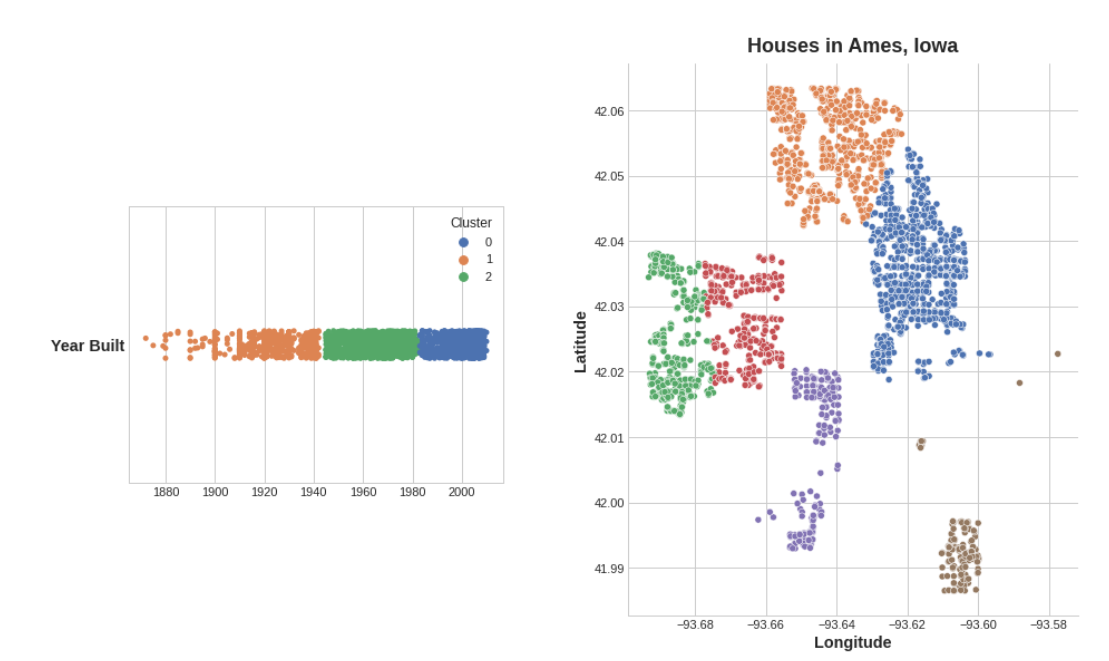

**2. K-Means Clustering**

There are a great many clustering algorithms. They differ primarily in how they measure "similarity" or "proximity" and in what kinds of features they work with. The algorithm we'll use, k-means, is intuitive and easy to apply in a feature engineering context. Depending on your application another algorithm might be more appropriate. 


K-means clustering measures similarity using ordinary stright-line distance (Euclidean distance, in other words). It creates clusters by placing a number of points, called centroids, inside the feature-space. Each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in "k-means" is how many centroids (that is, clusters) it creates. You define k your self. 


You could imagine each centroid capturing points through a sequence of radiating circles. When sets of circles from competing centroids overlap they form a line. The result is what's called a voronoi tessallation. The tessalation shows you to what clusters future data will be assigned; the tessallation is essentially what k-means learns from its training data.


Let's review how the k-means algorithm learns the clusters and what that means for feature engineering. We'll focus on three parameters from scikit-learn's implementation : n_cluster, max_iter, and n_init.

It's a simple two-step process. The algorithm starts by randomly initailizing some predefined number (n_clusters) of centriods. It then iterates over these two operation : 
1. assign points to the nearest cluster centroid
2. move each centroid to minimize the distance to its points

It iterates over these two steps until the centriods aren't moving anymore, or until some maximum number of iterations has passed (max_iter).


It often happens that the initail random position of the centroids ends in a poor clustering. For this reason the algorithm repeats a number of times(n_init) and return the clustering that has the least total distance between each point and its centroid, the optimal clustering. 


You many need to increase the max_iter for a large number of clusters or n_init for a complex dataset. Ordinarily though the only parameter you'll need to choose your self is n_cluster (k, that is). The best partitioning for a set of features depends on the model you're using and what you're trying to predict, so it's best to tune it like any hyperparamtetr (through cross-validation, say). 

In [3]:
# Example of making new feature using K-means

kmeans = KMeans(n_clusters = 6)

X['Cluster'] = kmeans.fit_predict(X)
X['Clutser'] = X['Cluster'].astype('category')

NameError: name 'KMeans' is not defined

# Principal Component Analysis 

# Target Encoding 